### Backtesting Bolinger Bands x RSI Strategy on the S&P 500

#### Trading Rules
- Stocks above the 200 day moving average
- Stocks closing 2.5 standard deviations below the 20 day Bolinger Band
- Entry: 3% below the previous day closing price and RSI under 30
- Exit: 10 day RSI above 40 or after 10 days

In [1]:
import pandas as pd
#getting the s&p list tickers
symbols = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
symbols = symbols.Symbol.to_list()
symbols[:10]

['MMM', 'AOS', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADM', 'ADBE', 'ADP']

In [2]:
import yfinance as yf
#downloading each dataframe
dfs = {}
for symbol in symbols:
    symbol = symbol.replace(".","-") #yf can't find stock tickers like BRK.B
    dfd = yf.download(symbol, start='2016-01-01', end='2021-12-31') 
    dfs[symbol] = pd.DataFrame(dfd) #array of dataframes

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CEG: Data doesn't exist for startDate = 1451581200, endDate = 1640883600
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*******

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [3]:
import ta

def applyindicators(df):
    df["SMA_200"] = df.Close.rolling(200).mean() #200 day moving average
    df['SMA_20'] = df.Close.rolling(20).mean() #20 day moving average
    df['stddev'] = df.Close.rolling(20).std() #20 day standard deviation
    df["upper"] = df.SMA_20 + 2.5 * df.stddev #upper bolinger band
    df["lower"] = df.SMA_20 - 2.5 * df.stddev #lower bolinger band
    df["rsi"] = ta.momentum.rsi(df.Close, 10)

In [4]:
import numpy as np

def conditions(df):
    #buy if closing price under lower BB & above 200 day MA & is 3% under the days low
    df["Buy"] = np.where((df.Close < df.lower) &
                        (df.Close > df.SMA_200) &
                        (0.97 * df.Close >= df.Low.shift(-1)) &
                         (df.rsi < 30), 1, 0)
    df["Sell"] = np.where((df.rsi > 40), 1, 0)
    df["Buyprice"] = 0.97 * df.Close
    df["Sellprice"] = df.Open.shift(-1)

In [5]:
def matchtrades(df):
    Buy_Sells = df[(df.Buy == 1) | (df.Sell == 1)]
    matched_Buy_Sells = Buy_Sells[(Buy_Sells.Buy.diff() == 1) | (Buy_Sells.Sell.diff() == 1)]
    return matched_Buy_Sells

In [6]:
def RSIcalc(df):
    df["SMA200"] = df.Close.rolling(200).mean()
    df["price_change"] = df["Adj Close"].pct_change()
    df["Upmove"] = df["price_change"].apply(lambda x: x if x > 0 else 0)
    df["Downmove"] = df["price_change"].apply(lambda x: x if x < 0 else 0)
    df["avg_Up"] = df["Upmove"].ewm(span=19).mean()
    df["avg_Down"] = df["Downmove"].ewm(span=19).mean()
    df = df.dropna()
    df["RS"] = df["avg_Up"] / df["avg_Down"]
    df["RSI"] = df["RS"].apply(lambda x: 100-(100/(x+1)))
    df.loc[(df["Adj Close"] > df["SMA200"]) & (df["RSI"] < 30), "Buy"] = "Yes"
    df.loc[(df["Adj Close"] < df["SMA200"]) | (df["RSI"] > 30), "Sell"] = "No"
    return df

In [9]:
trades = {}

for symbol in symbols:
    symbol = symbol.replace(".","-") #yf can't find stock tickers like BRK.B
    dfe = dfs[symbol]
    dfe.Close = dfe["Adj Close"]
    applyindicators(dfe)
    conditions(dfe)
    trade = matchtrades(dfe)
    if len(trade) > 0:
        trades[symbol] = trade
        
tradesdf = pd.concat(trades).reset_index().set_index("Date")
tradesdf 

,level_0,Open,High,Low,Close,Adj Close,Volume,SMA_200,SMA_20,stddev,upper,lower,rsi,Buy,Sell,Buyprice,Sellprice
Date,,,,,,,,,,,,,,,,,
2016-10-26,ABMD,119.900002,120.250000,109.379997,111.529999,111.529999,2881600,104.313200,126.607000,4.041594,136.710985,116.503015,18.708103,1,0,108.184099,101.510002
2016-11-11,ABMD,106.720001,110.239998,106.550003,110.010002,110.010002,630100,105.526200,113.161000,10.033846,138.245614,88.076386,45.916371,0,1,106.709702,111.080002
2018-07-27,ABMD,390.529999,392.000000,366.109985,369.170013,369.170013,1003700,285.239451,412.726498,15.881745,452.430861,373.022136,26.845160,1,0,358.094913,365.910004
2018-08-03,ABMD,393.720001,396.970001,371.390015,377.109985,377.109985,1019900,290.044051,402.016000,27.341333,470.369332,333.662668,40.083850,0,1,365.796686,376.160004
2020-09-04,ABMD,295.260010,295.260010,271.059998,275.890015,275.890015,511900,209.228400,305.078003,8.820869,327.130174,283.025832,29.224536,1,0,267.613314,269.790009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-05,WYNN,92.540001,98.870003,92.010002,98.680000,98.680000,6750200,114.988850,104.153500,6.244765,119.765414,88.541587,40.365092,0,1,95.719600,99.339996
2018-10-05,ZBRA,165.470001,167.089996,160.179993,162.229996,162.229996,294500,144.512700,173.275499,4.266712,183.942278,162.608720,28.710907,1,0,157.363096,161.250000
2018-10-15,ZBRA,156.990005,161.919998,155.210007,160.800003,160.800003,771100,146.027150,167.680000,9.137484,190.523710,144.836291,44.339788,0,1,155.976003,162.070007


In [10]:
tradesdf.level_0.unique()

array(['ABMD', 'ADBE', 'AES', 'ALGN', 'GOOGL', 'GOOG', 'AMZN', 'AMD',
       'ANSS', 'AAPL', 'ANET', 'ADSK', 'BRK-B', 'TECH', 'BIIB', 'BKNG',
       'CDNS', 'CZR', 'KMX', 'CBOE', 'CBRE', 'CE', 'CNC', 'CDAY', 'COO',
       'CPRT', 'CSX', 'DHR', 'DVA', 'DAL', 'XRAY', 'DXCM', 'FANG', 'DISH',
       'DIS', 'DLTR', 'EW', 'EA', 'ENPH', 'EPAM', 'FRC', 'FISV', 'FTNT',
       'GE', 'GL', 'GPN', 'HWM', 'IDXX', 'ILMN', 'IR', 'IPGP', 'IQV', 'J',
       'LYV', 'MA', 'MRNA', 'MHK', 'MOH', 'MPWR', 'MNST', 'MCO', 'NDAQ',
       'NFLX', 'NDSN', 'NVR', 'PAYC', 'PENN', 'PFG', 'QRVO', 'PWR',
       'REGN', 'CRM', 'NOW', 'SBNY', 'SWKS', 'SEDG', 'SIVB', 'SNPS',
       'TDY', 'TFX', 'TER', 'TSLA', 'TXT', 'TJX', 'TDG', 'TRMB', 'TWTR',
       'TYL', 'ULTA', 'UAA', 'UA', 'UAL', 'URI', 'UHS', 'VRSN', 'VRSK',
       'VRTX', 'WBD', 'WST', 'WDC', 'WRK', 'WYNN', 'ZBRA', 'ZBH'],
      dtype=object)

In [11]:
tradesdf["profit"] = (tradesdf.Sellprice.shift(-1) - tradesdf.Buyprice) / tradesdf.Buyprice

profitsdf = pd.DataFrame({"ticker": tradesdf[::2].level_0,
                         "profit": tradesdf[::2].profit,
                         "Buydates": tradesdf[::2].index,
                         "Selldates": tradesdf[1::2].index}).reset_index(drop=True)
profitsdf["time_in_market"] = profitsdf.Selldates - profitsdf.Buydates
sorted_profits = profitsdf.sort_values("Buydates").set_index("Buydates")
#maximum time in market is 10 days, you usually lose when it's more than 10 days
sorted_profits = sorted_profits[sorted_profits["time_in_market"] < pd.Timedelta(11, "D")]
sorted_profits

,ticker,profit,Selldates,time_in_market
Buydates,,,,
2016-12-01,NOW,0.069843,2016-12-05,4 days
2017-01-17,AMD,0.127512,2017-01-24,7 days
2017-03-14,UAL,0.046419,2017-03-23,9 days
2017-05-02,AMD,0.118836,2017-05-11,9 days
2017-06-09,FTNT,0.050265,2017-06-19,10 days
...,...,...,...,...
2021-06-17,UHS,0.033068,2021-06-21,4 days
2021-06-17,GL,0.035715,2021-06-25,8 days
2021-06-17,PFG,0.043103,2021-06-23,6 days


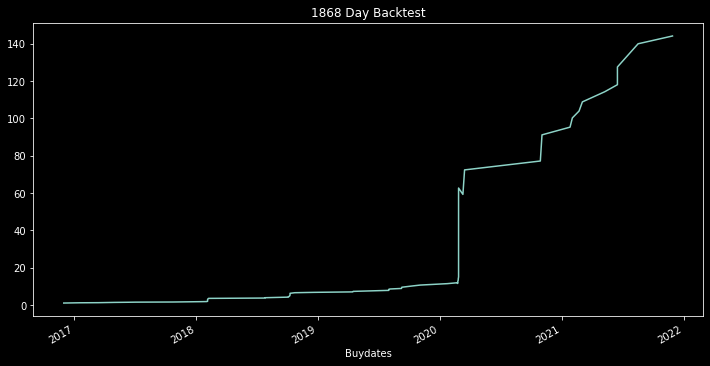

97.5% win rate
519.23% capital growth in 1868 days
6.57% average profit every 6 days
maximum loss of -5.44% a trade
maximum profit of 22.14% a trade


In [12]:
from matplotlib import pyplot as plt

timeframe = tradesdf.index.max() - tradesdf.index.min()

plt.style.use(["dark_background"])
plt.figure(figsize=(12,6))
(sorted_profits.profit+1).cumprod().plot()
plt.title(f"{timeframe.days} Day Backtest")
plt.show()

print(f"{round((len([x for x in sorted_profits.profit if x > 0])/len(sorted_profits)), 3)*100}% win rate")
print(f"{round(((sorted_profits.profit.mean() * len(sorted_profits)) * 100), 2)}% capital growth in {timeframe.days} days")
print(f"{round((sorted_profits.profit.mean() * 100), 2)}% average profit every {sorted_profits.time_in_market.mean().days} days")
print(f"maximum loss of {round((sorted_profits.profit.min() * 100), 2)}% a trade")
print(f"maximum profit of {round((sorted_profits.profit.max() * 100), 2)}% a trade")